In [44]:
import sys
sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit
import statsmodels.formula.api as smf

# Import et préparation des données

In [3]:
train = pd.read_csv("../data/application_train_vf.csv")
test = pd.read_csv("../data/application_test_vf.csv")

In [4]:
dataprep = DataPreparation(train, test, 0.3)

Type des variables convertis ✅
Valeurs manquantes traitées ✅
Discrétisation des variables numériques en cours ... 


  0%|          | 0/17 [00:00<?, ?it/s]

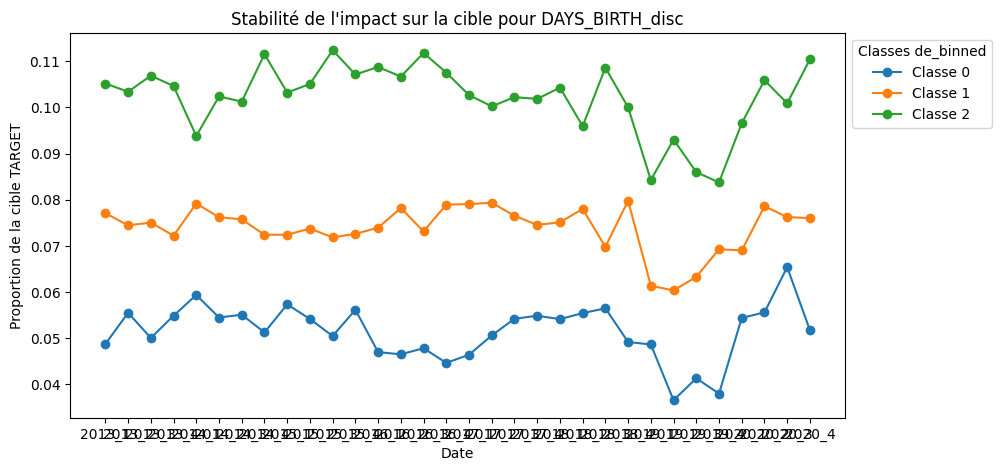

  6%|▌         | 1/17 [00:18<05:03, 18.98s/it]

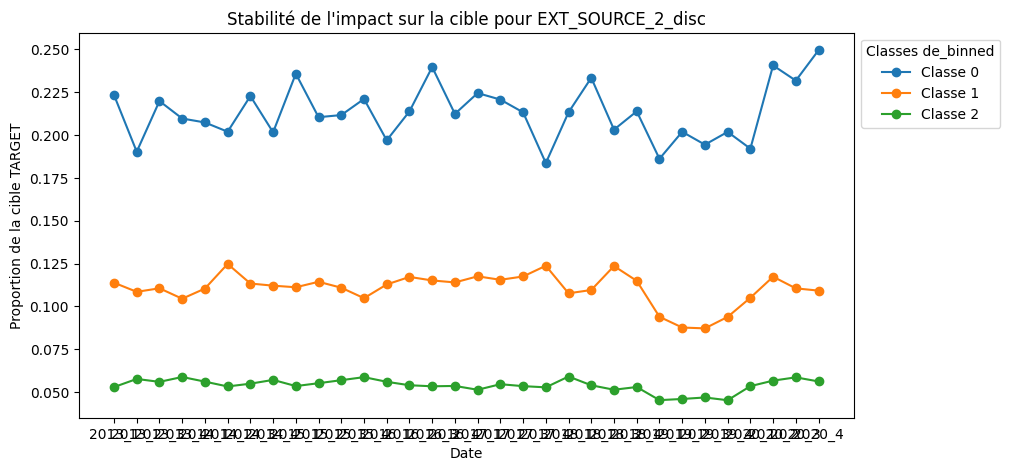

 12%|█▏        | 2/17 [00:38<04:47, 19.16s/it]

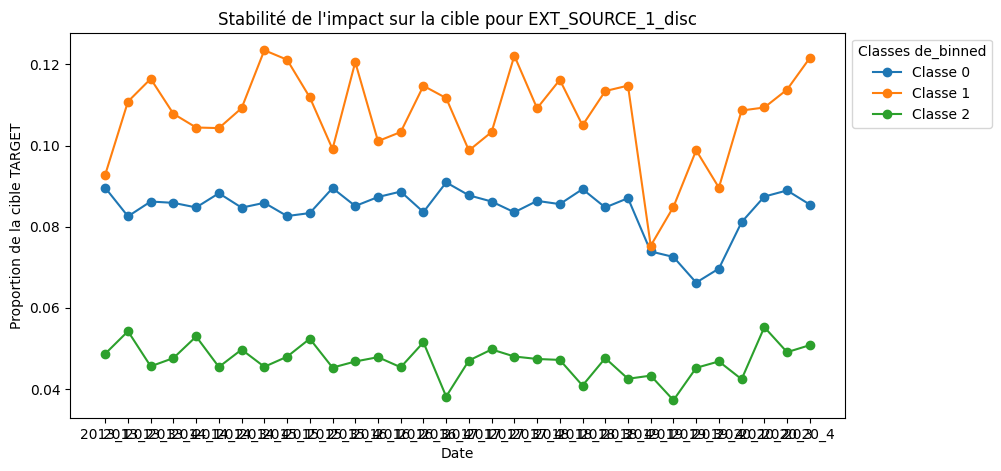

 18%|█▊        | 3/17 [00:57<04:27, 19.12s/it]

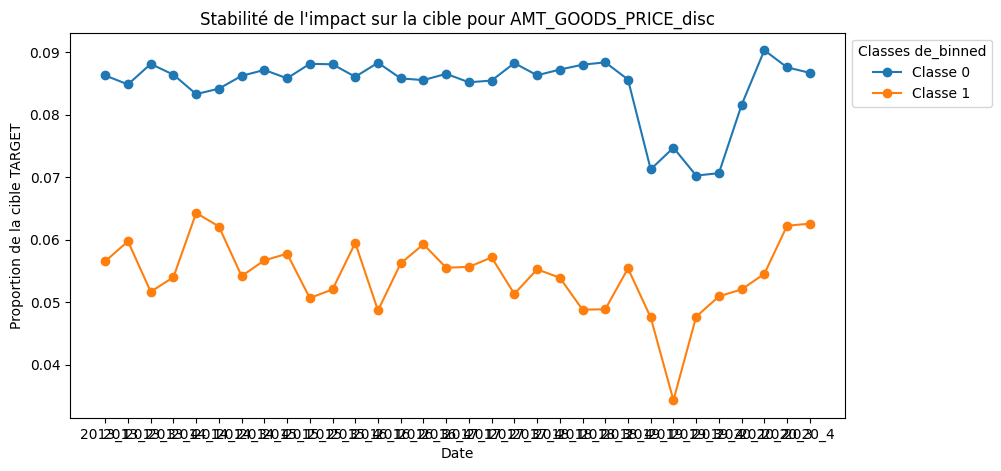

 24%|██▎       | 4/17 [01:14<03:57, 18.31s/it]

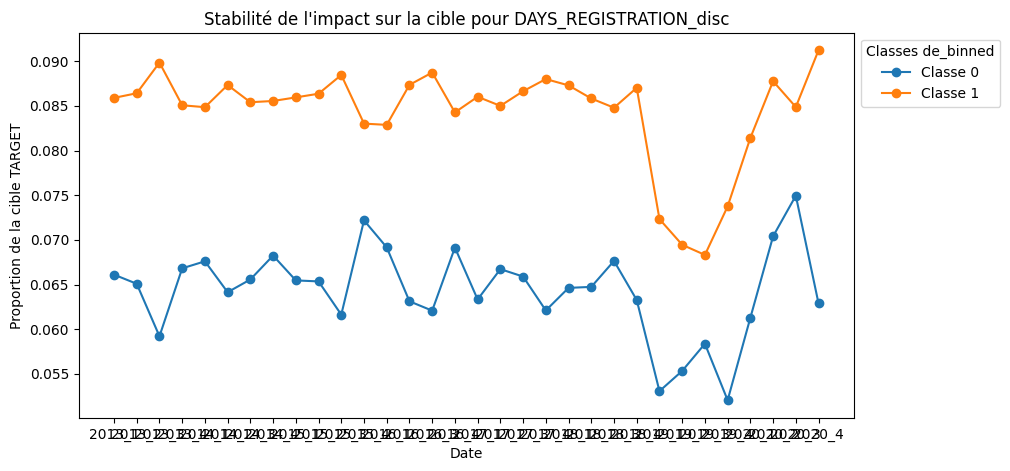

 29%|██▉       | 5/17 [01:31<03:35, 17.98s/it]

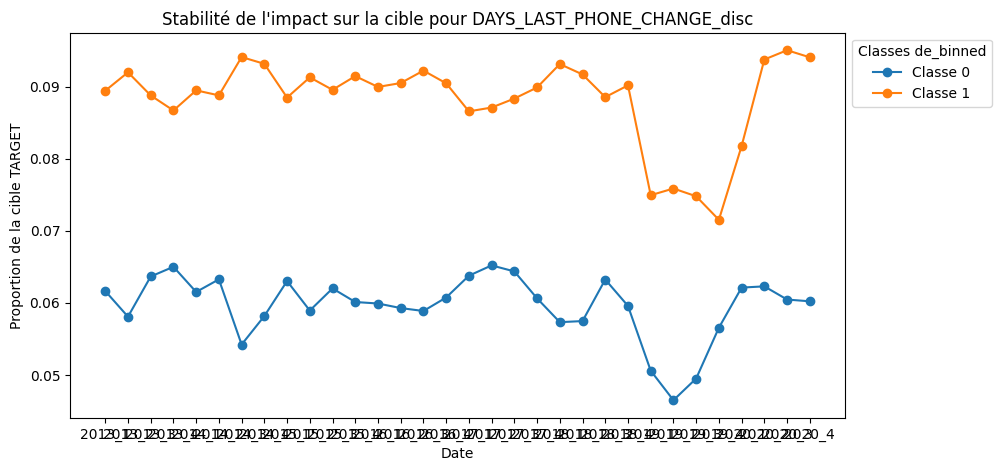

 35%|███▌      | 6/17 [01:50<03:20, 18.19s/it]

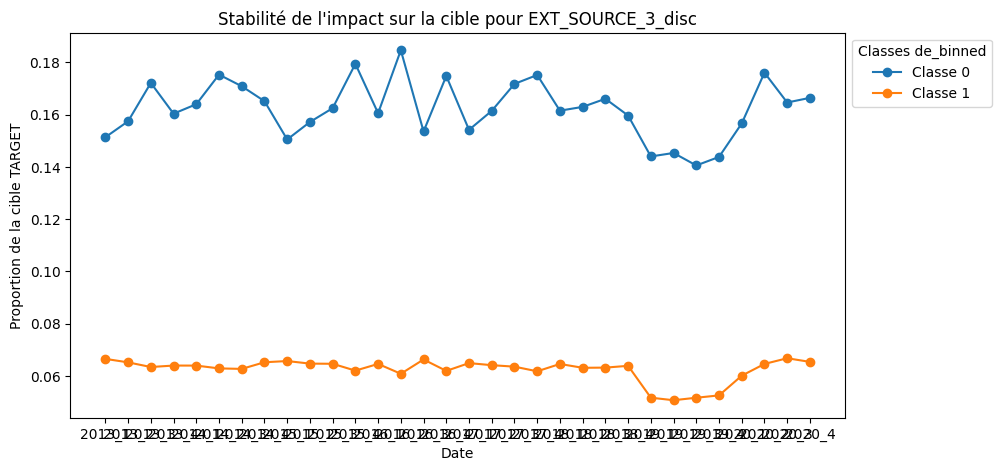

 41%|████      | 7/17 [02:07<02:58, 17.83s/it]

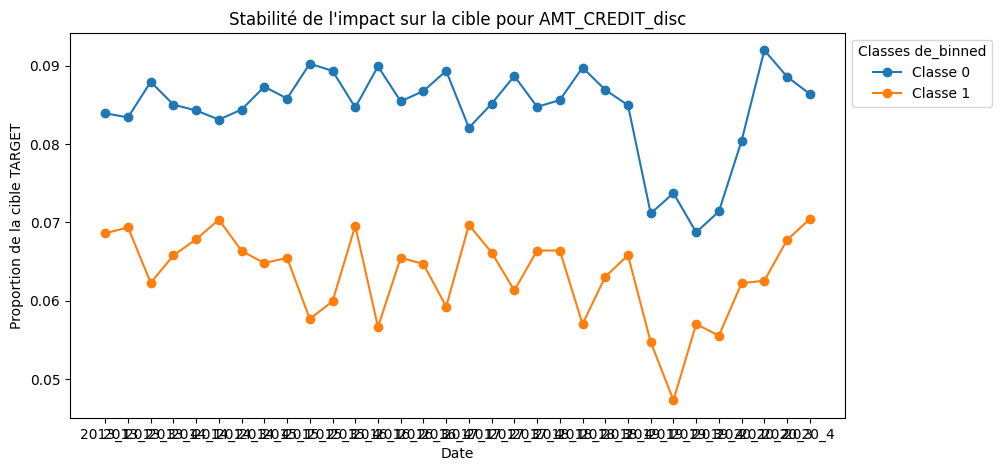

 47%|████▋     | 8/17 [02:24<02:39, 17.69s/it]

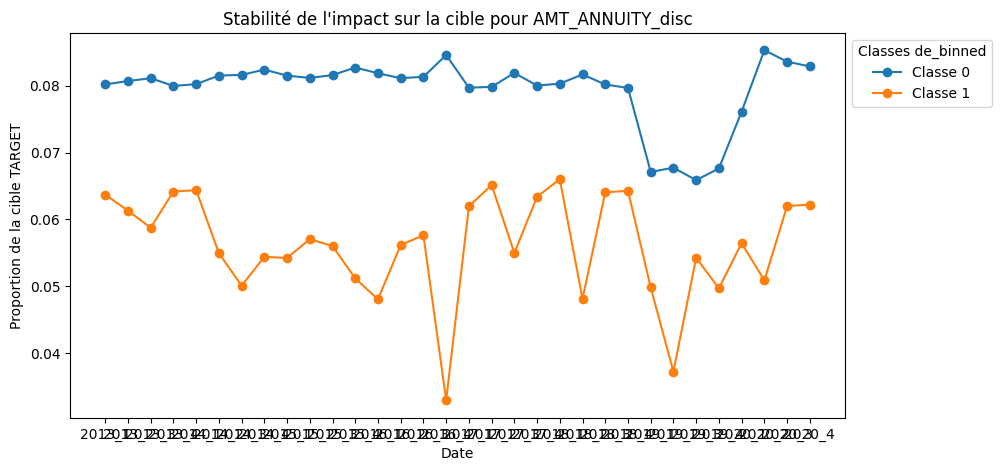

 53%|█████▎    | 9/17 [02:41<02:20, 17.50s/it]

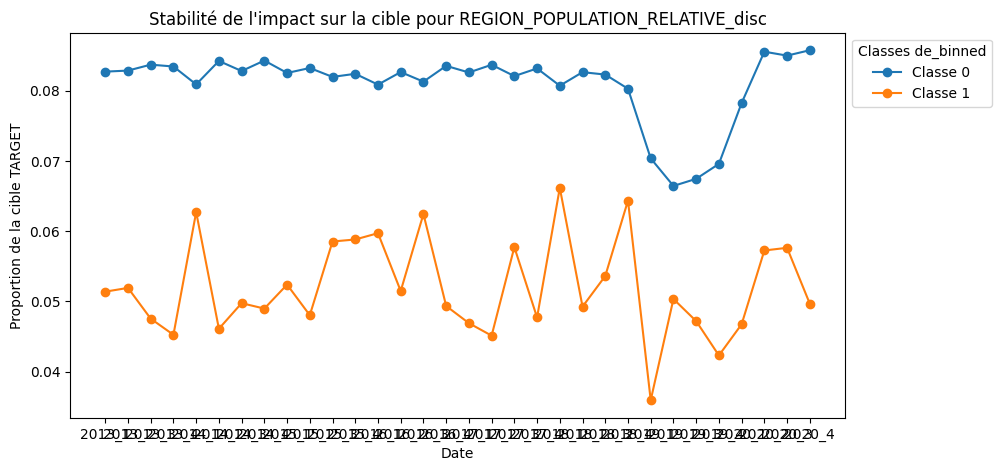

 59%|█████▉    | 10/17 [02:59<02:02, 17.47s/it]

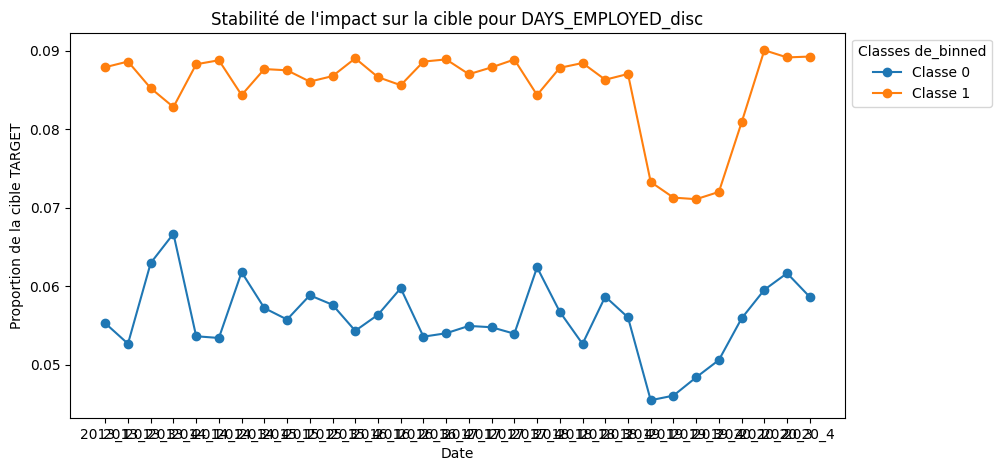

 65%|██████▍   | 11/17 [03:14<01:41, 16.88s/it]

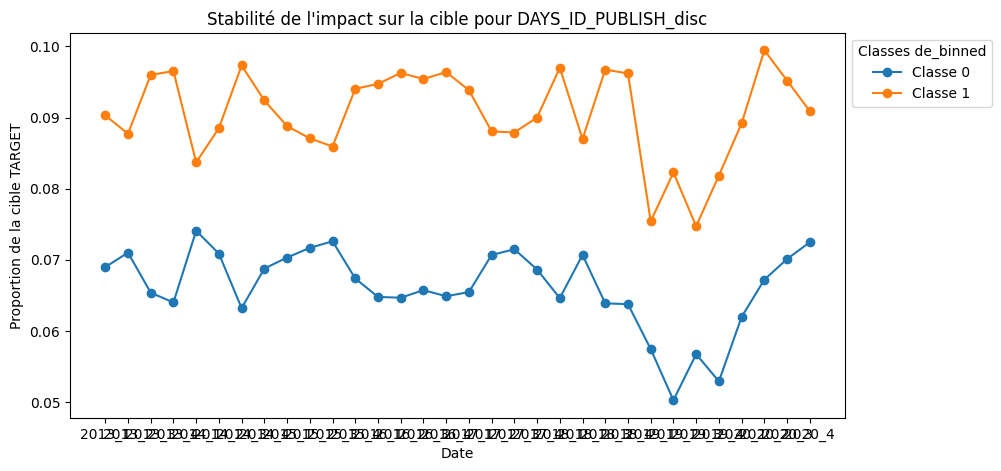

 71%|███████   | 12/17 [03:30<01:22, 16.52s/it]

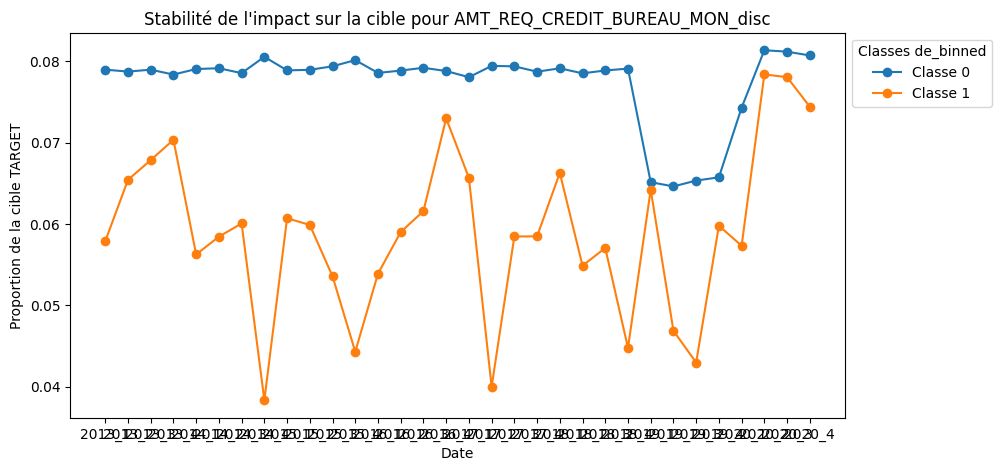

 76%|███████▋  | 13/17 [03:47<01:06, 16.52s/it]

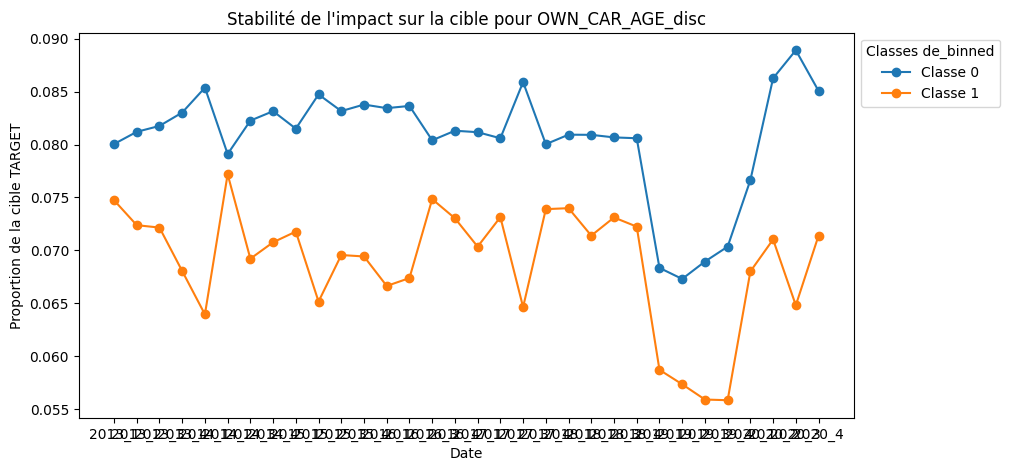

 82%|████████▏ | 14/17 [04:03<00:49, 16.58s/it]

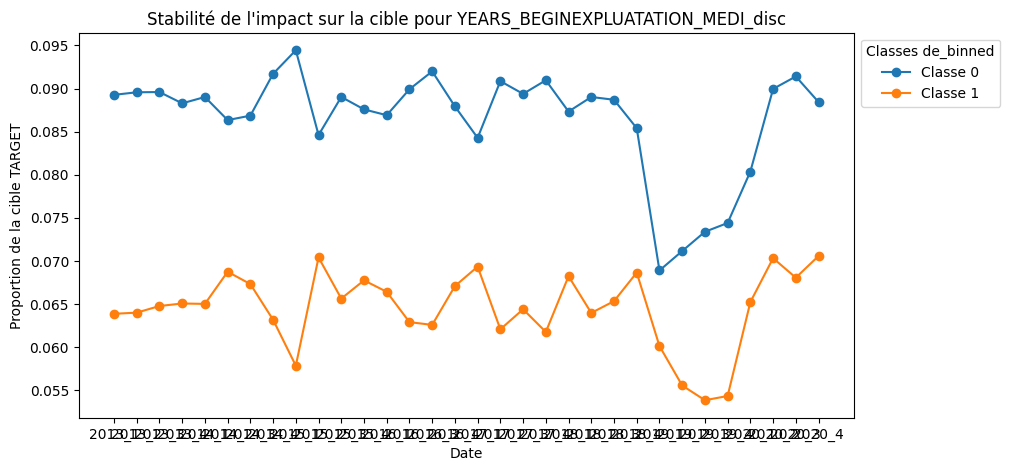

 88%|████████▊ | 15/17 [04:21<00:33, 16.76s/it]

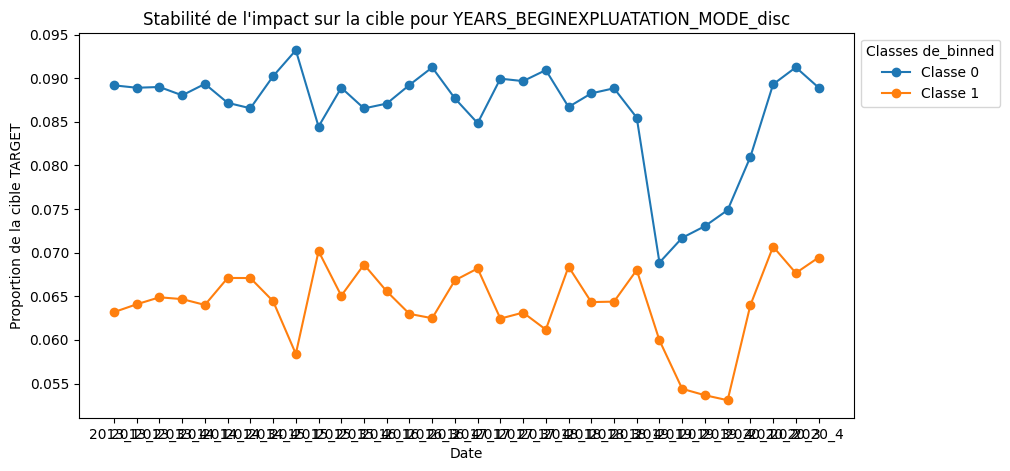

 94%|█████████▍| 16/17 [04:37<00:16, 16.81s/it]/Users/axel/Documents/École/Université/M2/M2_S1/Challenge_Nexialog/notebooks/../script/data_preparation.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.train[f'{variable}_disc_int'] = self.train[f'{variable}_disc'].map(dict_renommage)


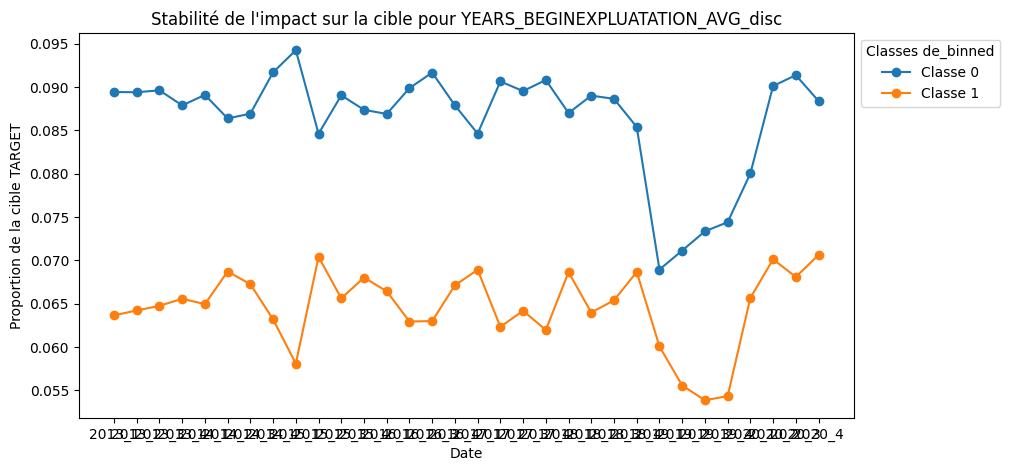

100%|██████████| 17/17 [04:55<00:00, 17.40s/it]
/Users/axel/Documents/École/Université/M2/M2_S1/Challenge_Nexialog/notebooks/../script/data_preparation.py:195: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.train['NAME_INCOME_TYPE_discret'] = np.select([self.train['NAME_INCOME_TYPE'].isin(low_income),
/Users/axel/Documents/École/Université/M2/M2_S1/Challenge_Nexialog/notebooks/../script/data_preparation.py:211: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.train['NAME_EDUCATION_TYPE_discret'] = np.select([self.train

Variables numériques discrétisées ✅
Discrétisation des variables catégorielles en cours ... 


/Users/axel/Documents/École/Université/M2/M2_S1/Challenge_Nexialog/notebooks/../script/data_preparation.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.train['OCCUPATION_TYPE_discret'] = np.select([self.train['OCCUPATION_TYPE'].isin(low_skilled),
/Users/axel/Documents/École/Université/M2/M2_S1/Challenge_Nexialog/notebooks/../script/data_preparation.py:248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.test['OCCUPATION_TYPE_discret'] = np.select([self.test['OCCUPATION_TYPE'].isin(low_skilled),


Variables catégorielles discrétisées ✅


In [5]:
train_prepared, test_prepared = dataprep.get_prepared_data()

In [6]:
df_train = train_prepared.copy()

In [ ]:
df_train["TARGET"] = df_train["TARGET"].astype("int")

In [ ]:
df_validation = df_train.iloc[280000:,:]
df_train = df_train.iloc[:280000,:]

# Modélisation

In [27]:
features = list(df_train.iloc[:,2:20].columns)

In [28]:
formula = f'TARGET ~ {" + ".join(f"C({var})" for var in features)}'

In [51]:
model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit_regularized(maxiter = 500, method='l1')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2467593866224251
            Iterations: 188
            Function evaluations: 189
            Gradient evaluations: 188


# Prédiction

In [52]:
pred = logit_model.predict(df_validation[features])

In [53]:
pred = pred.apply(lambda x : 0 if x < 0.5 else 1)

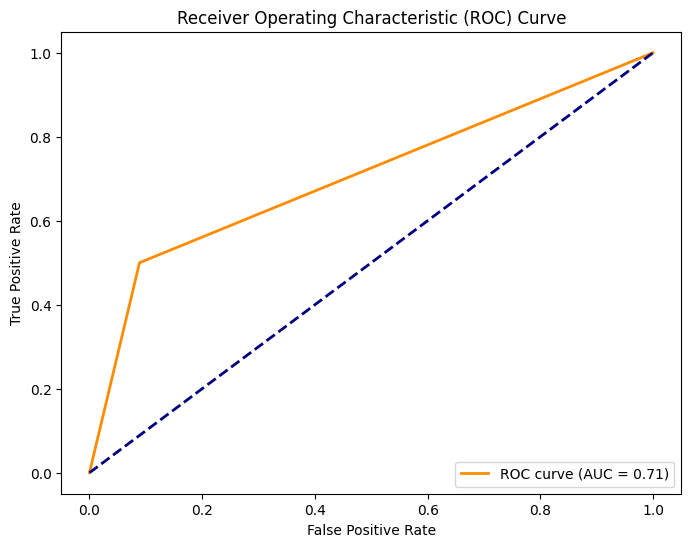

In [54]:
fpr, tpr, thresholds = roc_curve(pred, df_validation["TARGET"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [55]:
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

0.4112047500478837

# Grid Score

In [50]:
GridScore(df_train, logit_model).compute_grid_score()

,Variable,Modality,Coefficient,P-Value,Normalized Score,Pcentage_Défaut,Pcentage_Classe
0,DAYS_BIRTH_disc_int,[-19346--13359],-0.01,0.5250,612.43,3.00,41.11
1,DAYS_BIRTH_disc_int,[-25229--19347],-0.31,0.0000,706.21,1.38,27.30
2,EXT_SOURCE_2_disc_int,[0.13-0.45],-0.64,0.0000,809.34,2.90,26.54
3,EXT_SOURCE_2_disc_int,[0.45-0.85],-1.25,0.0000,1000.00,3.65,68.63
4,EXT_SOURCE_1_disc_int,[0.13-0.4],0.00,0.9924,609.31,1.43,13.49
5,EXT_SOURCE_1_disc_int,[0.4-0.96],-0.54,0.0000,778.09,1.33,28.74
6,AMT_GOODS_PRICE_disc_int,[679500.0-4050000.0],-0.40,0.0000,734.33,1.40,26.23
7,DAYS_REGISTRATION_disc_int,[-5714.0-0.0],0.08,0.0000,584.31,5.16,62.00
8,DAYS_LAST_PHONE_CHANGE_disc_int,[-4292.0--1050.0],-0.14,0.0000,653.07,2.38,40.35
9,EXT_SOURCE_3_disc_int,[0.31-0.9],-0.93,0.0000,899.98,5.28,85.73
